# 15文字カタカナ判別モデル

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline

## データの読み込み

In [8]:
train_data = np.load("../data/train_data.npy")
train_label = np.load("../data/train_label.npy")

In [9]:
# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')

train_data = train_data.reshape(-1, 28*28) # 配列形式変更
print("train_data.shape=", train_data.shape)

train_data.shape= (3000, 784)


In [10]:
# データ分割
train, test, train_labels, test_labels = train_test_split(train_data, train_label, test_size=0.3,shuffle=True) 
train = train.reshape(-1, 1, 28, 28)
test = test.reshape(-1, 1, 28, 28)

In [11]:
# テンソル型に変換
train = torch.from_numpy(train).float()
test = torch.from_numpy(test).float()
train_labels = torch.from_numpy(train_labels).float()
test_labels = torch.from_numpy(test_labels).float()

train.size()

torch.Size([2100, 1, 28, 28])

In [12]:
# DataLoaderへ渡すためにTensorDatasetを作成
train_dataset = TensorDataset(train, train_labels)
test_dataset = TensorDataset(test, test_labels)

# DataLoaderによりPyTorchモデルへデータを適用できる
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## ミニバッチ学習

In [13]:
class DefineNN(nn.Module):
    """
    畳み込み層 : 三層
    全ての活性化関数の前にバッチ正規化
    """
    def __init__(self):
        # nn.Moduleを継承
        super(DefineNN, self).__init__()
        
        # 畳み込み層   
        # Conv2d(画像のチャンネル数, 出力のチャンネル数, kernel_size(filter_num), stride=1, padding=0)
        self.conv_layers1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2, 2)
                                        )

        self.conv_layers2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2, 2)
                                        )

        self.conv_layers3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2, 2)
                                        )
        
        # 全結合層
        # Linear(input_size, output_size(hidden_size))
        self.fc1 = nn.Linear(64, 100)
        self.batchnorm = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 15)
        
        
    # ネットワーク構成を記述
    # ユニット数と活性化関数を決定
    def forward(self, x):
        # 畳み込み・プーリング処理
        x = self.conv_layers1(x)
        x = self.conv_layers2(x)
        x = self.conv_layers3(x) 
            
        # 列数がpool_output_pixelの形のtensorになるように変形
        x = x.view(-1, 64)
        # reluによるアクティベーション
        x = self.fc1(x)
        x = F.relu(self.batchnorm(x))
        out = self.fc2(x)
        return out

In [14]:
epochs = 20

loss_history = []
total_loss = 0

# データ拡張用
transform = transforms.Compose([
    # RandomAffine(回転、水平移動(縦, 横)、せん断(縦, 横)、空白輝度(R. G, B))
    transforms.RandomAffine(degrees=(-5, 5), translate=(0.0, 0.2), shear=(0, 5), fill=(1.)),
])

# CNNのオブジェクト生成
model = DefineNN()

# オプティマイザと損失関数を定義
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# モデルを学習モードにする
model.train()

for epoch in range(epochs):
    print("epoch=%s"%epoch)
    for data in train_loader:
        
        # loaderから得られるデータ data は[入力画像, ラベル]のタプル
        X_load, y_load = data
        # データ拡張の適用
        X_load = transform(X_load)
        # この時点での予測結果＝順伝播の計算
        y_pred = model(X_load)     
        # 損失を算出
        loss = criterion(y_pred, y_load)

        # 勾配を初期化
        optimizer.zero_grad()
        # 勾配を逆伝播
        loss.backward()
        # 逆伝播をもとにモデルのパラメータを更新
        optimizer.step()
        # total_lossへ加算代入
        total_loss += loss.item()
        
    # 1エポック毎の損失を計算
    loss_history.append(total_loss)
    total_loss = 0

epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9
epoch=10
epoch=11
epoch=12
epoch=13
epoch=14
epoch=15
epoch=16
epoch=17
epoch=18
epoch=19


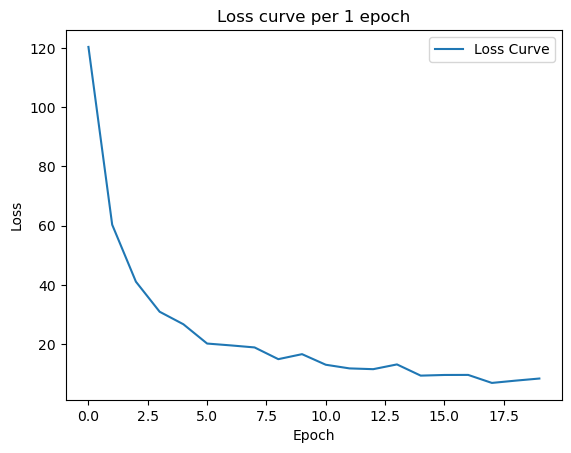

In [15]:
plt.plot(loss_history, label="Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curve per 1 epoch")
plt.legend();

In [16]:
# 確認用の辞書を作成
classes = {0:"a",1:"i",2:"u",3:"e",4:"o",5:"ka",6:"ki",7:"ku",8:"ke",9:"ko",10:"sa",11:"si",12:"su",13:"se",14:"so"}

# モデルを評価モードにし，パラメータの更新をさせないようにする
model.eval()

# 正解クラスのリスト
class_correct = [0] * 15
class_total = [0] * 15

# loaderからデータをロード
for data in test_loader:
    # 入力画像とラベルに分割
    images, labels = data
    # テストデータに対して結果を示す
    outputs = model(images)
    # 最も確率の高い値のindexを返す，つまり，モデルの予測結果を返す
    _, predicted = torch.max(outputs, 1)
    # 予測結果が正解ラベルと同じであればTrueを返すような2次元配列を生成
    c = (predicted == torch.argmax(labels, dim=1))
    # 正解数と全体数のカウント
    if labels.size(0) == batch_size:    
        for i in range(batch_size):
            label = torch.argmax(labels[i])
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
    # 余ったバッチ
    elif labels.size(0) != batch_size:
        for i in range(labels.size(0)):
            label = torch.argmax(labels[i])
            class_correct[label] += c[i].item()
            class_total[label] += 1

# 各ラベルにおけるAccuracyを算出
for i in range(15):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

# 全ラベルにおけるAccuracyを算出
print('Mean Accuracy : %2d %%' % (100 * sum(class_correct) / sum(class_total)))

Accuracy of     a : 100 %
Accuracy of     i : 96 %
Accuracy of     u : 98 %
Accuracy of     e : 90 %
Accuracy of     o : 100 %
Accuracy of    ka : 90 %
Accuracy of    ki : 96 %
Accuracy of    ku : 98 %
Accuracy of    ke : 70 %
Accuracy of    ko : 92 %
Accuracy of    sa : 89 %
Accuracy of    si : 96 %
Accuracy of    su : 96 %
Accuracy of    se : 84 %
Accuracy of    so : 98 %
Mean Accuracy : 93 %


In [17]:
# summary(model, input_dim)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 10, 10]          18,496
       BatchNorm2d-6           [-1, 64, 10, 10]             128
              ReLU-7           [-1, 64, 10, 10]               0
         MaxPool2d-8             [-1, 64, 5, 5]               0
            Conv2d-9             [-1, 64, 3, 3]          36,928
      BatchNorm2d-10             [-1, 64, 3, 3]             128
             ReLU-11             [-1, 64, 3, 3]               0
        MaxPool2d-12             [-1, 64, 1, 1]               0
           Linear-13                  [-1, 100]           6,500
      BatchNorm1d-14                  [